#Code needs to be run in order

###Install posthocs for statistics

In [4]:
!pip install scikit-posthocs

## Packages

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import shapiro, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scikit_posthocs as sp

## File reading

In [6]:
# Reads the Excel sheet and turns it into a dataframe
dataset_byTotal_60_cutoff = pd.read_excel("_byTotal_cutoff_60.xlsx")

print(dataset_byTotal_60_cutoff.columns)

Index(['Animal.ID', 'Grouping.Factor', 'Trial.Number', 'Sex', 'Cohort', 'Age',
       'Total.Hours', 'Wake.Epoch.Count', 'NREMS.Epoch.Count',
       'REMS.Epoch.Count', 'Wake.Seconds', 'NREMS.Seconds', 'REMS.Seconds',
       'NREMS.Onset', 'REMS.Onset', 'Sleep.Onset', 'NREMS.Offset',
       'REMS.Offset', 'Sleep.Offset', 'Latency.to.NREMS', 'Latency.to.REMS',
       'Latency.to.Sleep', 'Wake.Percent', 'NREMS.Percent', 'REMS.Percent',
       'Arousal.Count', 'Microarousal.Count', 'Wake.Bout.Count',
       'NREMS.Bout.Count', 'REMS.Bout.Count', 'Sleep.Bout.Count',
       'Sleep.Cycle.Count', 'Avg.Wake.Bout.Duration',
       'Avg.NREMS.Bout.Duration', 'Avg.REMS.Bout.Duration',
       'Avg.Sleep.Bout.Duration', 'Wake.NREMS.Transition.Count',
       'Wake.REMS.Transition.Count', 'NREMS.Wake.Transition.Count',
       'NREMS.REMS.Transition.Count', 'REMS.Wake.Transition.Count',
       'REMS.NREMS.Transition.Count', 'Propensity.to.enter.NREMS',
       'Propensity.to.Wake.from.NREMS', 'Propensi

##Data retrieval/distribution

Text(0.5, 1.0, 'Size of the treatments group for SleepInvestigatoR and the plots')

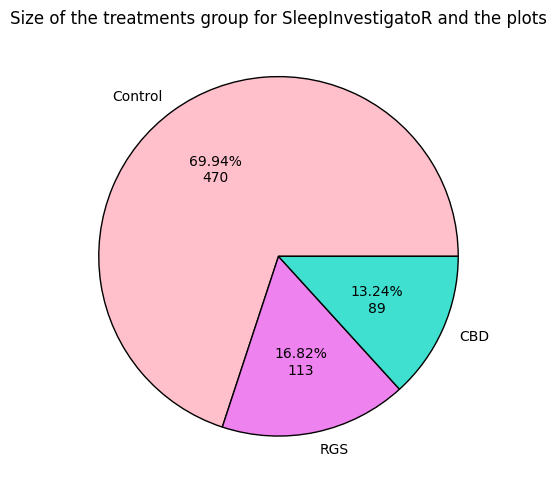

In [7]:
# Order of the treatments for the plots
custom_order_treatments = ["Control", "RGS", "CBD"]

# Convert the Grouping.Factor column to a categorical type with the custom order
dataset_byTotal_60_cutoff["Grouping.Factor"] = pd.Categorical(dataset_byTotal_60_cutoff["Grouping.Factor"], categories=custom_order_treatments, ordered=True)

# Groups the dataframe per treatment
treatments_grouped = (dataset_byTotal_60_cutoff.groupby("Grouping.Factor",
                                                        observed=False))

# Obtain the size of each treatment group
size_dataset = treatments_grouped.size()

def fmt(x):
  """Function that calculates the percentage of each treatment group and makes
  it be able to be put on the pie chart

  argument:
  x: percentage of each group

  returns:
  the size of the treatment group and the percentage of it
  """

  return '{:.2f}%\n{:.0f}'.format(x, size_dataset.sum()*x/100)

# Make the subplots
fig, ax = plt.subplots(layout="constrained")

# Plot the pie chart with the size of the treatments
size_dataset.plot(kind="pie",
                  colors=["Pink", "Violet", "turquoise"],
                  autopct=fmt,
                  wedgeprops={'edgecolor': 'black'})
ax.set_title("Size of the treatments group for SleepInvestigatoR and the plots")


#Statistical test function

In [8]:
def statistical_tests(feature_list):
  """
  This function applies the Shapiro-Wilk test to each specified feature individually.
  Based on the resulting p-values, it then selects and performs either the
  Kruskal-Wallis test (for non-normal distributions) or a one-way ANOVA (for normal distributions).

  arguments:
  feature_list: list containing the column names whose significance needs to be
  calculated

  returns:
  The results from the shapiro test and the potential significance of each
  treatment combination
  """
  # Store results
  normalized_distribution_p_values = {}
  unique_treatments = dataset_byTotal_60_cutoff["Grouping.Factor"].unique()

  # Check whether the data is normally distributed for each feature across
  # treatments by going through each feature in the list and obtaining the data
  # from that feature and performing the shapiro test
  for feature in feature_list:
      p_values = []
      for treatment in dataset_byTotal_60_cutoff["Grouping.Factor"].unique():
          data = dataset_byTotal_60_cutoff[
                dataset_byTotal_60_cutoff["Grouping.Factor"] == treatment
                ][feature].dropna()

          stat, p = shapiro(data)
          p_values.append(p)

      normalized_distribution_p_values[feature] = p_values

      # Checks whether all three treatments are normally distributed and
      # peforms a one way anova test and a tukey if an signficant difference is found
      if all(p > 0.05 for p in p_values):
            print(f"\n{feature}: All groups are normally distributed. Performing one-way ANOVA.\n")

            anova_stat, anova_p = f_oneway(*data)
            print(f"ANOVA result for {feature}: F = {anova_stat:.4f}, p = {anova_p:.4f}\n")

            if anova_p < 0.05:
                print(f"Significant difference found in {feature}. Running Tukey test...")

                # Prepare data and group labels for Tukey
                data_all = dataset_byTotal_60_cutoff[feature]
                group_labels = dataset_byTotal_60_cutoff["Grouping.Factor"]

                # Tukey post hoc test
                tukey = pairwise_tukeyhsd(endog=data_all, groups=group_labels, alpha=0.05)
                print(tukey)

            else:
                print(f"No significance found in {feature}\n")

      # Peforms a kruskal wallis test if an treatment in the feature isn't
      # normally distributed and an Dunn's post hoc test if an signficant feature is found
      else:
          print(f"\n{feature}: non normally distributed group found. Performing Kruskal-Wallis.\n")

          # Drop NaNs
          groups = [dataset_byTotal_60_cutoff[dataset_byTotal_60_cutoff["Grouping.Factor"] == treatment][feature].dropna()
          for treatment in dataset_byTotal_60_cutoff["Grouping.Factor"].unique()]

          # Keep only valid groups (length > 1, more than 1 unique value)
          valid_groups = [g for g in groups if len(g) > 1 and g.nunique() > 1]


          if len(valid_groups) >= 2:
            stat, p = kruskal(*valid_groups)
            print(f"Kruskal-Wallis result for feature: {feature}: H = {stat:.4f}, p = {p:.4f}\n")

            if p < 0.05:
              print(f"Significant difference found in {feature}. Running Dunn's post hoc test...")

              # dunn's post hoc test
              dunn_results = sp.posthoc_dunn(
                dataset_byTotal_60_cutoff,
                val_col=feature,
                group_col="Grouping.Factor",
                p_adjust='bonferroni'
              )
              print(f"\nDunn's post hoc test results for {feature}:\n")
              print(dunn_results)

            else:
              print("No significant differences between treatments found\n")

          else:
            print(f"Skipping Kruskal-Wallis for {feature}: not enough valid groups (need ≥2 with varied data).")
  print("\n\nStatistical test are performed, calculations will be performed next\n")

# State percentage per treatment
Shows potential differences between the average percentages of sleep states in treatments



Wake.Percent: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Wake.Percent: H = 20.4725, p = 0.0000

Significant difference found in Wake.Percent. Running Dunn's post hoc test...

Dunn's post hoc test results for Wake.Percent:

          Control       RGS       CBD
Control  1.000000  0.000026  0.328851
RGS      0.000026  1.000000  0.142116
CBD      0.328851  0.142116  1.000000

NREMS.Percent: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: NREMS.Percent: H = 25.5172, p = 0.0000

Significant difference found in NREMS.Percent. Running Dunn's post hoc test...

Dunn's post hoc test results for NREMS.Percent:

          Control       RGS       CBD
Control  1.000000  0.000001  1.000000
RGS      0.000001  1.000000  0.005139
CBD      1.000000  0.005139  1.000000

REMS.Percent: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: REMS.Percent

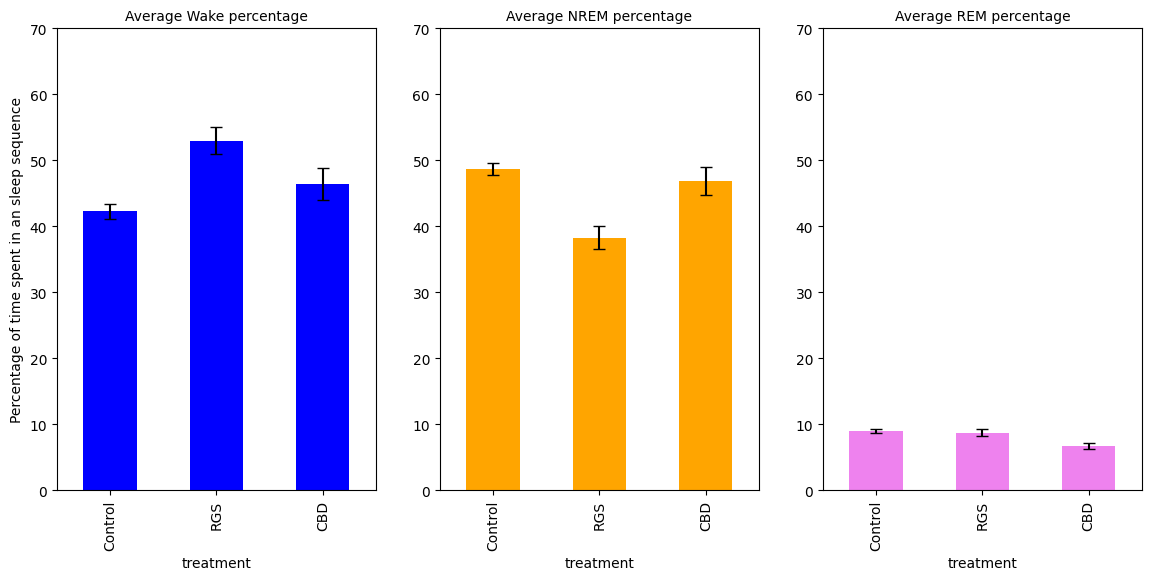

In [9]:
# Perform statistical tests
features = ["Wake.Percent", "NREMS.Percent", "REMS.Percent"]
statistical_tests(features)


print("\n")

# Makes the value percentages by multiplying them by a 100. Reload the dataset,
# if you want to rerun this code
dataset_byTotal_60_cutoff["Wake.Percent"] = dataset_byTotal_60_cutoff["Wake.Percent"] * 100
dataset_byTotal_60_cutoff["NREMS.Percent"] = dataset_byTotal_60_cutoff["NREMS.Percent"] * 100
dataset_byTotal_60_cutoff["REMS.Percent"] = dataset_byTotal_60_cutoff["REMS.Percent"] * 100

# Makes a dataframe containing the mean percentage of the different sleep
# states per treatment
treatments_grouped_percent = treatments_grouped[["Wake.Percent", "NREMS.Percent",
                                         "REMS.Percent"]].mean()

print("Average percentage per sleep state: ","\n", treatments_grouped_percent, "\n")

# Makes a dataframe containing the standard error of the percentage
# of the different sleep states per treatment
treatments_grouped_standard_error_percent = treatments_grouped[
                                                              ["Wake.Percent",
                                                              "NREMS.Percent",
                                                              "REMS.Percent"
                                                              ]].sem()
print(treatments_grouped_standard_error_percent)

# Makes three barplots with the treatment groups on the X axis
# and the average REM percentage on the Y axis, with the standard error as
# the error bars
fig, ax = plt.subplots(1,3, figsize=(14,6))

treatments_grouped_percent["Wake.Percent"].plot(kind="bar",
                                                ax=ax[0],
                                                yerr=treatments_grouped_standard_error_percent["Wake.Percent"],
                                                capsize=4,
                                                color=["Blue"])
ax[0].set_xlabel("treatment")
ax[0].set_ylabel("Percentage of time spent in an sleep sequence")
ax[0].set_title("Average Wake percentage", fontsize=10)
ax[0].set_ylim(0, 70)


treatments_grouped_percent["NREMS.Percent"].plot(kind="bar",
                                                ax=ax[1],
                                                yerr=treatments_grouped_standard_error_percent["NREMS.Percent"],
                                                capsize=4,
                                                 color=["Orange"])
ax[1].set_xlabel("treatment")
ax[1].set_title("Average NREM percentage", fontsize=10)
ax[1].set_ylim(0, 70)

treatments_grouped_percent["REMS.Percent"].plot(kind="bar",
                                                ax=ax[2],
                                                yerr=treatments_grouped_standard_error_percent["REMS.Percent"],
                                                capsize=4,
                                                color=["Violet"])
ax[2].set_xlabel("treatment")
ax[2].set_title("Average REM percentage", fontsize=10)
ax[2].set_ylim(0, 70)


plt.show()

# Divides the columns by 100 again to avoid the multiplications to stack with
# every rerun
dataset_byTotal_60_cutoff["Wake.Percent"] = dataset_byTotal_60_cutoff["Wake.Percent"] / 100
dataset_byTotal_60_cutoff["NREMS.Percent"] = dataset_byTotal_60_cutoff["NREMS.Percent"] / 100
dataset_byTotal_60_cutoff["REMS.Percent"] = dataset_byTotal_60_cutoff["REMS.Percent"] / 100


# Average state bout duration plot
Shows us a possible effect of the treatments on the bout duration for the different states


Avg.Wake.Bout.Duration: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Avg.Wake.Bout.Duration: H = 1.1066, p = 0.5750

No significant differences between treatments found


Avg.NREMS.Bout.Duration: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Avg.NREMS.Bout.Duration: H = 89.8626, p = 0.0000

Significant difference found in Avg.NREMS.Bout.Duration. Running Dunn's post hoc test...

Dunn's post hoc test results for Avg.NREMS.Bout.Duration:

              Control           RGS           CBD
Control  1.000000e+00  5.968575e-14  1.311108e-03
RGS      5.968575e-14  1.000000e+00  4.417667e-17
CBD      1.311108e-03  4.417667e-17  1.000000e+00

Avg.REMS.Bout.Duration: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Avg.REMS.Bout.Duration: H = 6.2283, p = 0.0444

Significant difference found in Avg.REMS.Bout.Duration. Running Dunn's po

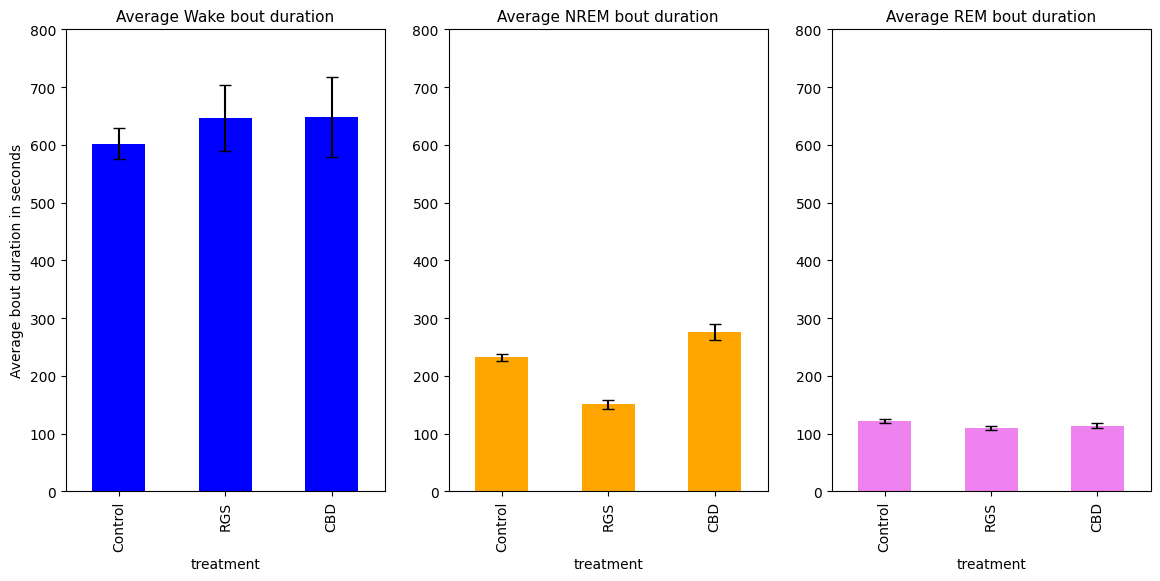

In [10]:
# Perform statistical tests
features = ["Avg.Wake.Bout.Duration", "Avg.NREMS.Bout.Duration", "Avg.REMS.Bout.Duration"]
statistical_tests(features)

# Makes a dataframe containing the mean bout duration of the different sleep
# states per treatment and multiplies it by 60 to make it seconds instead of minutes
treatments_grouped_duration = treatments_grouped[["Avg.Wake.Bout.Duration",
                                                                  "Avg.NREMS.Bout.Duration",
                                                                  "Avg.REMS.Bout.Duration"]
                                                                  ].mean() * 60
print("Average bout duration for the different states: ", "\n",
      treatments_grouped_duration, "\n")

# Makes a dataframe containing the standard error of the average bout duration
# per sleep state and per treatment and multiplies it by 60 to make
# it seconds instead of minutes
treatments_grouped_duration_standard_error = treatments_grouped[["Avg.Wake.Bout.Duration",
                                                                  "Avg.NREMS.Bout.Duration",
                                                                  "Avg.REMS.Bout.Duration"]
                                                                  ].sem() * 60

print("Average standard error for the different states: ", "\n",
      treatments_grouped_duration_standard_error)

# Makes three barplots with the treatment groups on the X axis
# and the average REM percentage on the Y axis, with the standard error as
# the error bars
fig, ax = plt.subplots(1,3, figsize=(14,6))

treatments_grouped_duration["Avg.Wake.Bout.Duration"].plot(kind="bar",
                                                ax=ax[0],
                                                yerr=treatments_grouped_duration_standard_error["Avg.Wake.Bout.Duration"],
                                                capsize=4,
                                                color=["Blue"])
ax[0].set_xlabel("treatment")
ax[0].set_ylabel("Average bout duration in seconds")
ax[0].set_title("Average Wake bout duration", fontsize=11)
ax[0].set_ylim(0,800)


treatments_grouped_duration["Avg.NREMS.Bout.Duration"].plot(kind="bar",
                                                ax=ax[1],
                                                yerr=treatments_grouped_duration_standard_error["Avg.NREMS.Bout.Duration"],
                                                capsize=4,
                                                 color=["Orange"])
ax[1].set_xlabel("treatment")
ax[1].set_title("Average NREM bout duration", fontsize=11)
ax[1].set_ylim(0,800)

treatments_grouped_duration["Avg.REMS.Bout.Duration"].plot(kind="bar",
                                                ax=ax[2],
                                                yerr=treatments_grouped_duration_standard_error["Avg.REMS.Bout.Duration"],
                                                capsize=4,
                                                color=["Violet"])
ax[2].set_xlabel("treatment")
ax[2].set_title("Average REM bout duration", fontsize=11)
ax[2].set_ylim(0,800)


plt.show()


# State onset and offset per treatments
Shows the possible effect of the treatments on the locations of the first and last bout for every sleep state


Onset significance


NREMS.Onset: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: NREMS.Onset: H = 30.4338, p = 0.0000

Significant difference found in NREMS.Onset. Running Dunn's post hoc test...

Dunn's post hoc test results for NREMS.Onset:

          Control       RGS       CBD
Control  1.000000  0.000002  1.000000
RGS      0.000002  1.000000  0.000041
CBD      1.000000  0.000041  1.000000

REMS.Onset: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: REMS.Onset: H = 6.5870, p = 0.0371

Significant difference found in REMS.Onset. Running Dunn's post hoc test...

Dunn's post hoc test results for REMS.Onset:

          Control       RGS       CBD
Control  1.000000  0.172746  0.696084
RGS      0.172746  1.000000  1.000000
CBD      0.696084  1.000000  1.000000

Sleep.Onset: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Sleep.Onse

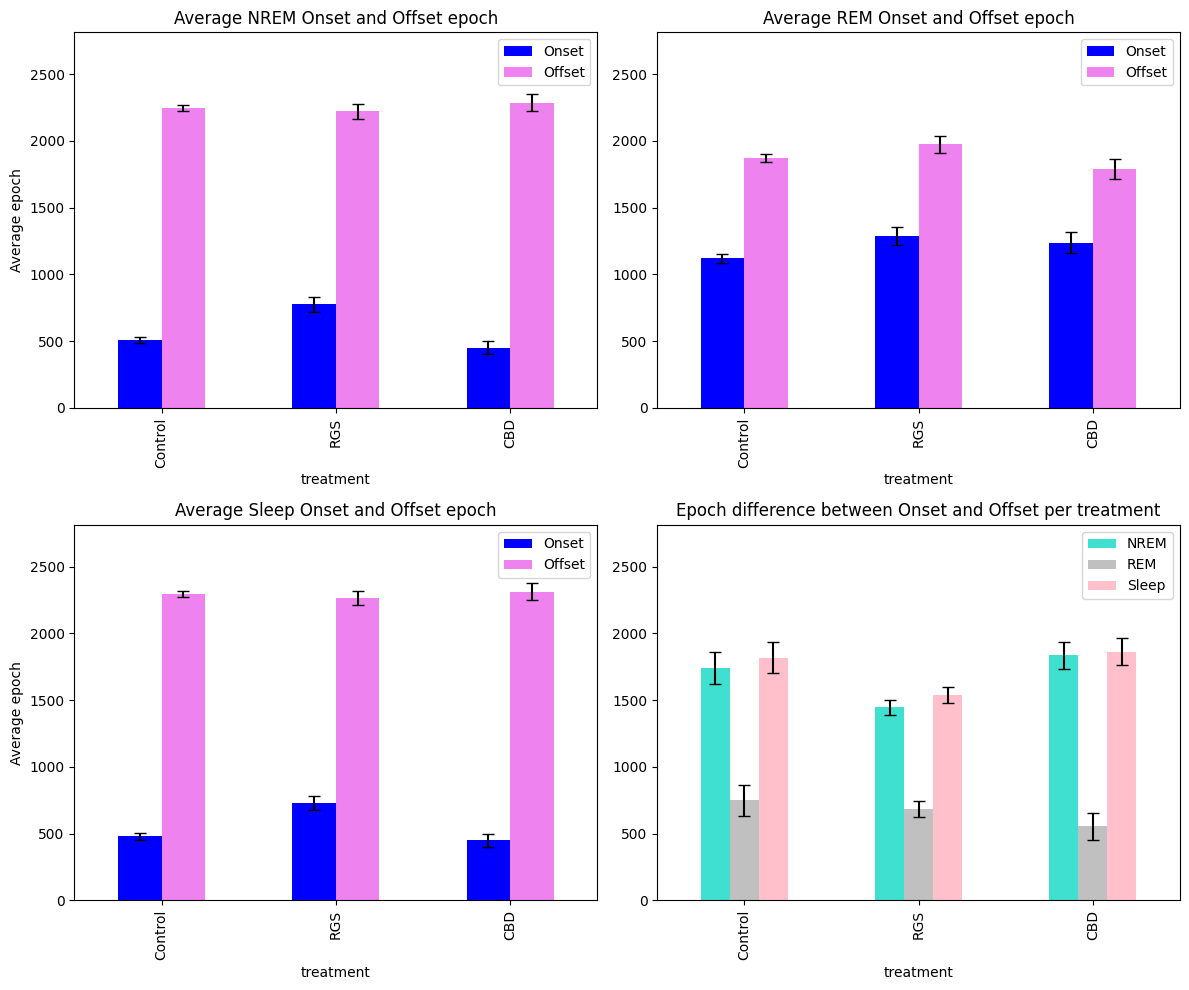

In [11]:
# Perform statistical tests
feature_onset = ["NREMS.Onset", "REMS.Onset", "Sleep.Onset"]
feature_offset = ["NREMS.Offset", "REMS.Offset", "Sleep.Offset"]

print("Onset significance\n")
statistical_tests(feature_onset)

print("\nOffset significance")
statistical_tests(feature_offset)

# Calculate means for onset and offset
onset_offset_means = {col: treatments_grouped[[f"{col}.Onset", f"{col}.Offset"]].mean()
                      for col in ["NREMS", "REMS", "Sleep"]}

# Calculate SEM for onset and offset
treatments_grouped_Onset_Offset_sem = treatments_grouped[["NREMS.Onset", "REMS.Onset",
                                                          "Sleep.Onset", "NREMS.Offset",
                                                          "REMS.Offset", "Sleep.Offset"]].sem()

# Create DataFrame using dictionary comprehension
df = pd.DataFrame({f"{col}.{time}": onset_offset_means[col][f"{col}.{time}"]
                   for col in ["NREMS", "REMS", "Sleep"]
                   for time in ["Onset", "Offset"]})

# Calculate differences
for col in ["NREMS", "REMS", "Sleep"]:
    df[f"{col}_difference"] = df[f"{col}.Offset"] - df[f"{col}.Onset"]
    treatments_grouped_Onset_Offset_sem[f"{col}_difference_sem"] = df[f"{col}_difference"].sem()

# Get the maximum value for each column
max_values = df.max()

# Get the highest of the max values
highest_max = max_values.max()

# Function to plot the onset and offset columns
def plot_onset_offset(ax, df, columns, yerr, title, xlabel, ylabel, ylim, colors):
  """
  Function that takes different arguments to make a bar plot

  arguments:
  ax: which axis of the grid the bar plot needs to be plotted in
  data: the dataframe for the plot
  columns: which columns of the dataframe contains the data
  yerr: the dataframe containing the standard error for the columns
  title: what the title of the plot should be
  xlabel: what the xlabel for the plot should be
  ylabel: what the ylabel for the plot should be
  ylim: limit of the y-axis
  colors: the colors used for the bar plot
  legend: what the legend for the plot should contain

  returns:
  The desired bar plot
  """
  # The code that plots the columns of the dataframe with the given arguments
  df[columns].plot(kind="bar", ax=ax, yerr=yerr, capsize=4, color=colors)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)
  ax.set_title(title)
  ax.set_ylim(0, ylim)
  ax.legend(["Onset", "Offset"])

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot NREMS Onset and Offset
plot_onset_offset(axs[0, 0],
                  df,
                   ["NREMS.Onset", "NREMS.Offset"],
                  treatments_grouped_Onset_Offset_sem[["NREMS.Onset", "NREMS.Offset"]],
                  "Average NREM Onset and Offset epoch",
                  "treatment",
                  "Average epoch",
                  highest_max + 500,
                   ["Blue", "Violet"])

# Plot REMS Onset and Offset
plot_onset_offset(axs[0, 1],
                  df,
                   ["REMS.Onset", "REMS.Offset"],
                  treatments_grouped_Onset_Offset_sem[["REMS.Onset", "REMS.Offset"]],
                  "Average REM Onset and Offset epoch",
                  "treatment",
                  "",
                  highest_max + 500,
                   ["Blue", "Violet"])

# Plot Sleep Onset and Offset
plot_onset_offset(axs[1, 0],
                  df,
                   ["Sleep.Onset", "Sleep.Offset"],
                  treatments_grouped_Onset_Offset_sem[["Sleep.Onset", "Sleep.Offset"]],
                  "Average Sleep Onset and Offset epoch",
                  "treatment", "Average epoch",
                  highest_max + 500,
                   ["Blue", "Violet"])

# Plot difference figures
yerr_values = treatments_grouped_Onset_Offset_sem[["NREMS_difference_sem", "REMS_difference_sem", "Sleep_difference_sem"]].values

df[["NREMS_difference", "REMS_difference", "Sleep_difference"]].plot(kind="bar",
                                                                     ax=axs[1,1],
                                                                     yerr=yerr_values,
                                                                     capsize=4,
                                                                     color=["Turquoise", "Silver", "Pink"])
axs[1,1].set_ylim(0, highest_max + 500)
axs[1,1].set_xlabel("treatment")
axs[1,1].legend(["NREM", "REM", "Sleep"])
axs[1,1].set_title("Epoch difference between Onset and Offset per treatment")



plt.tight_layout()
plt.show()

# Sleep fragmentation, arousal count and microarousal count
Shows the impact of the treatments on the polyphasicity of the rat (how many times it's awake) by looking at the average number of wake per minute or the total amount of wake bouts of any length.


Sleep.Fragmentation.Index: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Sleep.Fragmentation.Index: H = 105.4250, p = 0.0000

Significant difference found in Sleep.Fragmentation.Index. Running Dunn's post hoc test...

Dunn's post hoc test results for Sleep.Fragmentation.Index:

              Control           RGS           CBD
Control  1.000000e+00  3.439241e-16  1.378976e-04
RGS      3.439241e-16  1.000000e+00  1.122282e-20
CBD      1.378976e-04  1.122282e-20  1.000000e+00

Arousal.Count: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Arousal.Count: H = 83.0806, p = 0.0000

Significant difference found in Arousal.Count. Running Dunn's post hoc test...

Dunn's post hoc test results for Arousal.Count:

              Control           RGS           CBD
Control  1.000000e+00  7.042501e-10  2.837649e-07
RGS      7.042501e-10  1.000000e+00  4.800436e-19
CBD      2.837649e-07  4.8004

(0.0, 15.0)

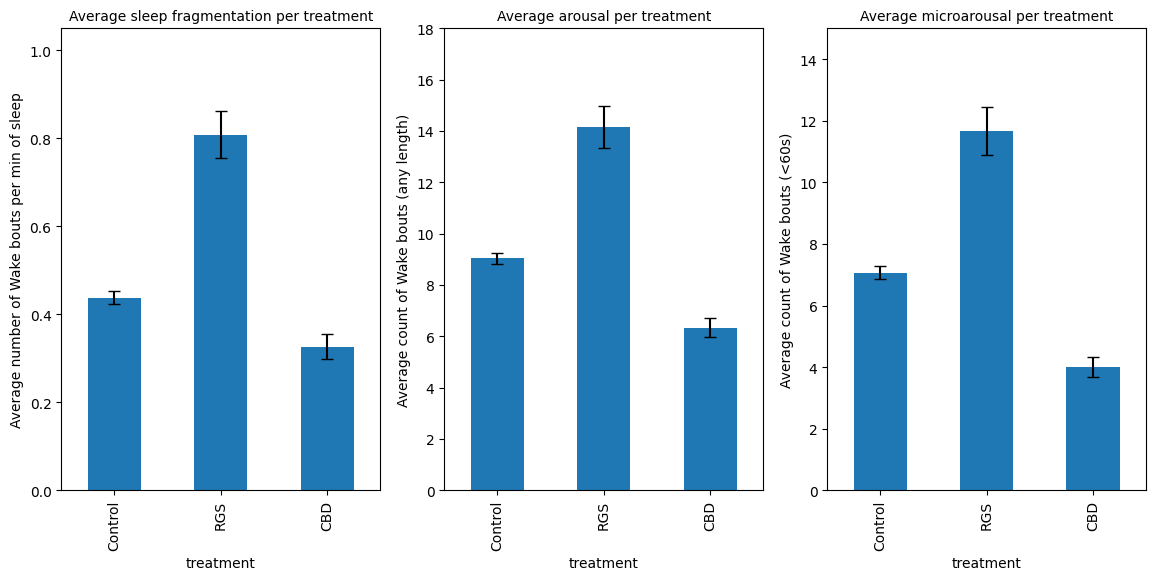

In [12]:
# Perform statistical tests
feature_list = ["Sleep.Fragmentation.Index", "Arousal.Count", "Microarousal.Count"]
statistical_tests(feature_list)

# Calculate the mean of the sleep fragmentation index and arousal count
# per treatment
sleep_fragmentation_mean = treatments_grouped["Sleep.Fragmentation.Index"].mean()
arousal_count_mean = treatments_grouped["Arousal.Count"].mean()

# Calculate the standard error of the same columns
sleep_fragmentation_sem = treatments_grouped["Sleep.Fragmentation.Index"].sem()
arousal_count_sem = treatments_grouped["Arousal.Count"].sem()

Microarousals_mean = treatments_grouped["Microarousal.Count"].mean()
Microarousals_sem = treatments_grouped["Microarousal.Count"].sem()

# Print results
print("Average sleep fragmentation index: ", "\n" , sleep_fragmentation_mean)
print("\n", "Standard error of the fragmentation index: ", "\n", sleep_fragmentation_sem)
print("\n", "Average arousal count: ", "\n", arousal_count_mean)
print("\n", "Standard error of the arousal count: ", "\n", arousal_count_sem, "\n")
print("Average microarousals count: ", Microarousals_mean, "\n")
print("Standard error for the average microarousals: ", Microarousals_sem)

# Set subplots in a 1X2 grid
fig, ax = plt.subplots(1,3, figsize=(14,6))

# Plot the sleep fragmentation index
sleep_fragmentation_mean.plot(kind="bar",
                              ax=ax[0],
                              yerr=sleep_fragmentation_sem,
                              capsize=4)
ax[0].set_xlabel("treatment")
ax[0].set_ylabel("Average number of Wake bouts per min of sleep")
ax[0].set_title("Average sleep fragmentation per treatment", fontsize=10)
ax[0].set_ylim(0,1.05)

# Plot the arousal count
arousal_count_mean.plot(kind="bar",
                        ax=ax[1],
                        yerr=arousal_count_sem,
                        capsize=4)
ax[1].set_xlabel("treatment")
ax[1].set_ylabel("Average count of Wake bouts (any length)")
ax[1].set_title("Average arousal per treatment", fontsize=10)
ax[1].set_ylim(0,18)

# Plot the microarousal plot
Microarousals_mean.plot(kind="bar",
                        ax=ax[2],
                        yerr=Microarousals_sem,
                        capsize=4)
ax[2].set_xlabel("treatment")
ax[2].set_ylabel("Average count of Wake bouts (<60s)")
ax[2].set_title("Average microarousal per treatment", fontsize=10)
ax[2].set_ylim(0,15)


# All the state to state transitions
Shows the average number of specific transitions between states


Wake.NREMS.Transition.Count: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Wake.NREMS.Transition.Count: H = 83.9660, p = 0.0000

Significant difference found in Wake.NREMS.Transition.Count. Running Dunn's post hoc test...

Dunn's post hoc test results for Wake.NREMS.Transition.Count:

              Control           RGS           CBD
Control  1.000000e+00  1.621855e-11  6.705991e-06
RGS      1.621855e-11  1.000000e+00  1.011811e-18
CBD      6.705991e-06  1.011811e-18  1.000000e+00

Wake.REMS.Transition.Count: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Wake.REMS.Transition.Count: H = 22.1075, p = 0.0000

Significant difference found in Wake.REMS.Transition.Count. Running Dunn's post hoc test...

Dunn's post hoc test results for Wake.REMS.Transition.Count:

          Control       RGS      CBD
Control  1.000000  0.003782  0.00025
RGS      0.003782  1.000000  1.00000
CBD      

Text(0.5, 0, 'treatment')

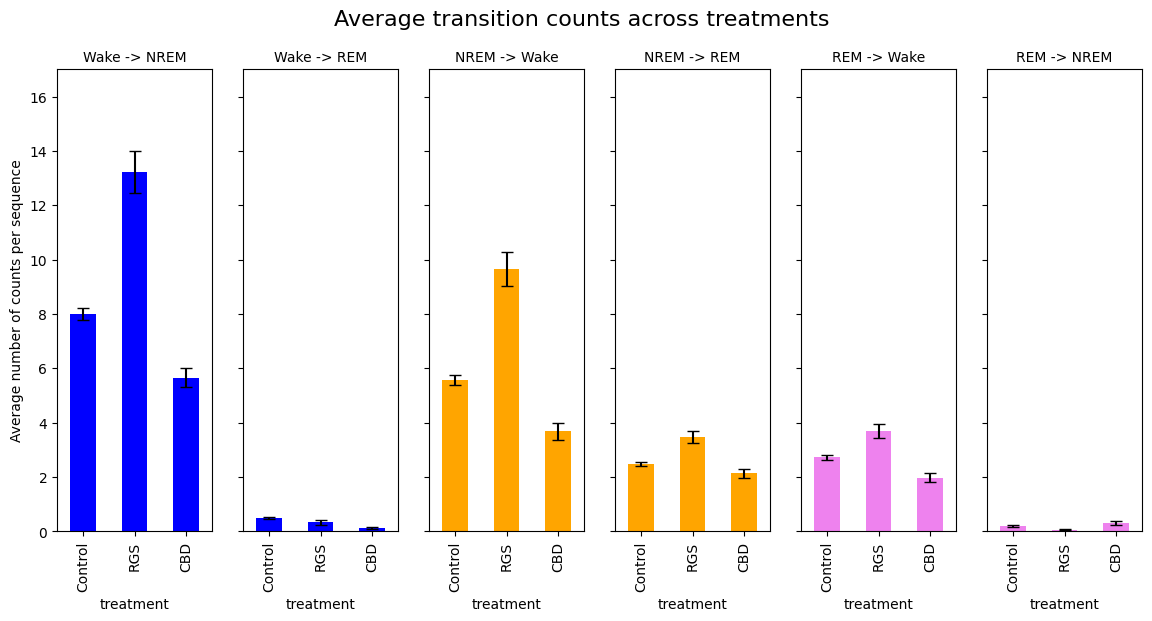

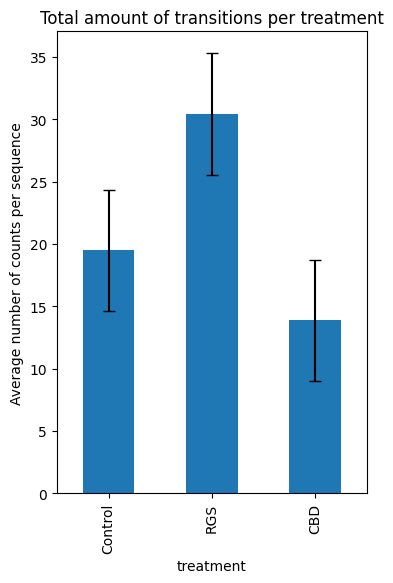

In [13]:
# Perform statistical tests
features_transitions = ["Wake.NREMS.Transition.Count", "Wake.REMS.Transition.Count",
                        "NREMS.Wake.Transition.Count", "NREMS.REMS.Transition.Count",
                        "REMS.Wake.Transition.Count", "REMS.NREMS.Transition.Count"]
statistical_tests(features_transitions)

# Creates empty dictionaries that will be filled with the mean or standard error
# of the transition column
transition_counts_mean = {}
transition_counts_sem = {}

# Obtains the needed columns by going trying all possible combinitations
# (e.g. Wake.Wake.Transition count, Wake.NREM.Transition.Count, ect) and
# checking which are columns of the grouped dataset and adding the mean and sem
# of the existing columns to their respective dictionary
for col in ["Wake", "NREMS", "REMS"]:
    for second_column in ["Wake", "NREMS", "REMS"]:
        key = f"{col}.{second_column}.Transition.Count"
        if key in dataset_byTotal_60_cutoff:
          transition_counts_mean[key] = treatments_grouped[key].mean()
          transition_counts_sem[key] = treatments_grouped[key].sem()

# Turn the dictionaries into dataframes and calculate the sum of transitions
# per treatment
transition_counts_mean_dataframe = pd.DataFrame(transition_counts_mean)
transition_counts_sem_dataframe = pd.DataFrame(transition_counts_sem)
transition_counts_sum_dataframe = transition_counts_mean_dataframe.sum(axis=1)

# Print results
print("The average amount of transitions: ", "\n",
      transition_counts_mean_dataframe, "\n")
print("The standard error of the transitions: ", "\n",
      transition_counts_sem_dataframe, "\n")
print("The average amount of transitions: ", "\n",
      transition_counts_sum_dataframe, "\n")

# Calculate the standard error of the mean for the sum
transition_counts_sum_sem = transition_counts_sum_dataframe.sem()




# Get the maximum value for each column
max_values = transition_counts_mean_dataframe.max()

# Get the highest of the max values to have a limit for the y-axis
highest_max = max_values.max()

# Make the subplots in a 1X6 grid
fig, ax = plt.subplots(1, 6, sharey=True, figsize=(14, 6))
fig.suptitle("Average transition counts across treatments", fontsize=16)

transition_colors = {
    "Wake": "Blue",
    "NREMS": "Orange",
    "REMS": "Violet"
}

transition_counts_mean_dataframe["Wake.NREMS.Transition.Count"].plot(kind="bar",
                                                ax=ax[0],
                                                yerr=transition_counts_sem_dataframe["Wake.NREMS.Transition.Count"],
                                                capsize=4,
                                                color=transition_colors["Wake"])
ax[0].set_xlabel("treatment")
ax[0].set_ylabel("Average number of counts per sequence")
ax[0].set_title("Wake -> NREM", fontsize=10)
ax[0].set_ylim(0,17)


transition_counts_mean_dataframe["Wake.REMS.Transition.Count"].plot(kind="bar",
                                                ax=ax[1],
                                                yerr=transition_counts_sem_dataframe["Wake.REMS.Transition.Count"],
                                                capsize=4,
                                                color=transition_colors["Wake"])
ax[1].set_xlabel("treatment")
ax[1].set_title("Wake -> REM", fontsize=10)



transition_counts_mean_dataframe["NREMS.Wake.Transition.Count"].plot(kind="bar",
                                                ax=ax[2],
                                                yerr=transition_counts_sem_dataframe["NREMS.Wake.Transition.Count"],
                                                capsize=4,
                                                color=transition_colors["NREMS"])
ax[2].set_xlabel("treatment")
ax[2].set_title("NREM -> Wake", fontsize=10)

transition_counts_mean_dataframe["NREMS.REMS.Transition.Count"].plot(kind="bar",
                                                ax=ax[3],
                                                yerr=transition_counts_sem_dataframe["NREMS.REMS.Transition.Count"],
                                                capsize=4,
                                                color=transition_colors["NREMS"])
ax[3].set_xlabel("treatment")
ax[3].set_title("NREM -> REM", fontsize=10)

transition_counts_mean_dataframe["REMS.Wake.Transition.Count"].plot(kind="bar",
                                                ax=ax[4],
                                                yerr=transition_counts_sem_dataframe["REMS.Wake.Transition.Count"],
                                                capsize=4,
                                                color=transition_colors["REMS"])
ax[4].set_xlabel("treatment")
ax[4].set_title("REM -> Wake", fontsize=10)

transition_counts_mean_dataframe["REMS.NREMS.Transition.Count"].plot(kind="bar",
                                                ax=ax[5],
                                                yerr=transition_counts_sem_dataframe["REMS.NREMS.Transition.Count"],
                                                capsize=4,
                                                color=transition_colors["REMS"])
ax[5].set_xlabel("treatment")
ax[5].set_title("REM -> NREM", fontsize=10)

fig, axs = plt.subplots(figsize=(4, 6))

# Plot the transition sum plot. Not used the function due to the differences
# between this plot and the other three plots
transition_counts_sum_dataframe.plot(kind="bar",
                                     ax=axs,
                                     yerr=transition_counts_sum_sem,
                                     capsize=4)
axs.set_title("Total amount of transitions per treatment")
axs.set_ylabel("Average number of counts per sequence")
axs.set_xlabel("treatment")

# Propensity to enter a state per treatment / Latency to enter Wake after state

Shows the effect of the treatments on the state --> wake latency and the
wake --> state latency



Propensity.to.enter.NREMS: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Propensity.to.enter.NREMS: H = 1.0595, p = 0.5887

No significant differences between treatments found


Propensity.to.enter.REMS: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Propensity.to.enter.REMS: H = 0.1592, p = 0.9235

No significant differences between treatments found


Propensity.to.enter.Sleep: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Propensity.to.enter.Sleep: H = 0.5223, p = 0.7702

No significant differences between treatments found


Propensity.to.Wake.from.NREMS: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Propensity.to.Wake.from.NREMS: H = 43.2158, p = 0.0000

Significant difference found in Propensity.to.Wake.from.NREMS. Running Dunn's post hoc test...

Dunn's post hoc te

Text(0.5, 1.0, 'Average Wake latency after sleep onset')

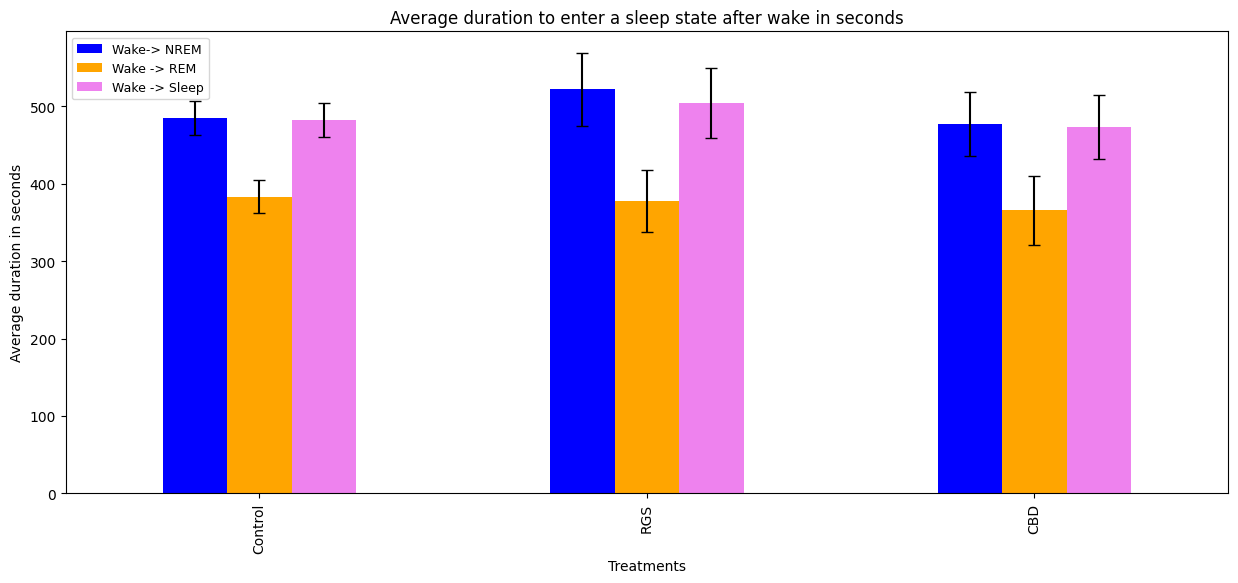

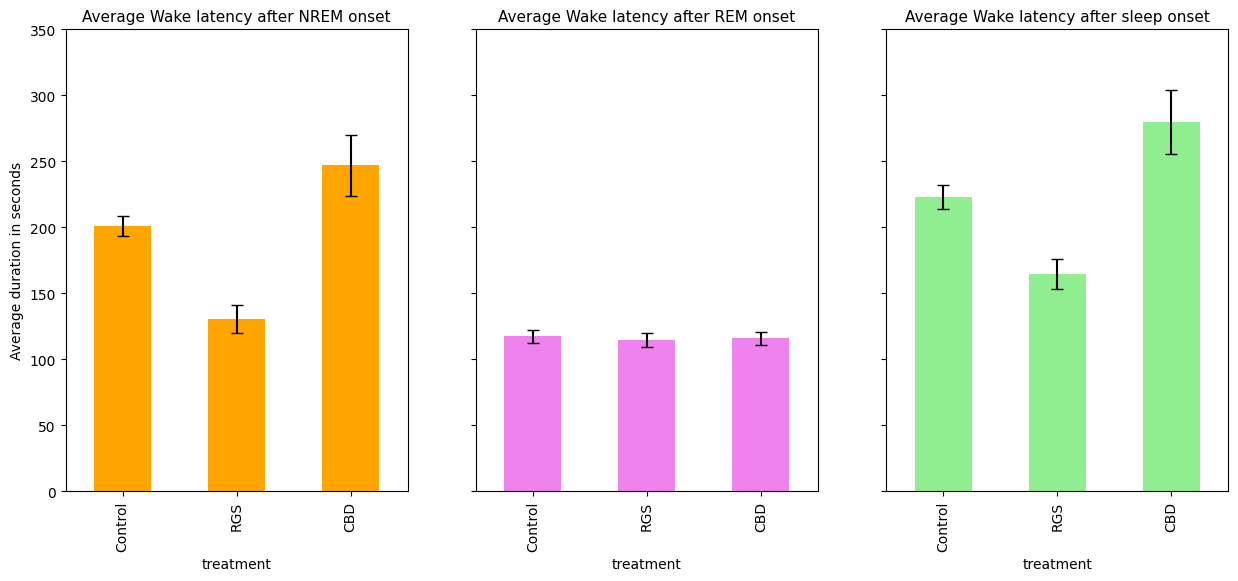

In [14]:
# Perform statistical tests
features_propensity = ["Propensity.to.enter.NREMS", "Propensity.to.enter.REMS", "Propensity.to.enter.Sleep",
                       "Propensity.to.Wake.from.NREMS", "Propensity.to.Wake.from.REMS", "Propensity.to.Wake.from.Sleep"]
statistical_tests(features_propensity)

# Creates empty dictionaries that will be filled with the mean or standard error
# of the propensity column
propensity_state_mean = {}
propensity_state_sem = {}
propensity_wake_state_mean = {}
propensity_wake_state_sem = {}

# Obtains the needed columns by going trying all possible combinitations
# (e.g. Propensity.to.enter.NREMS, Propensity.to.enter.REMS ect) and
# checking which are columns of the grouped dataset and adding the mean and sem
# of the existing columns to their respective dictionary (multiplied by 60, to
# to have it in seconds)
for col in ["NREMS", "REMS", "Sleep"]:
  key = f"Propensity.to.enter.{col}"
  if key in dataset_byTotal_60_cutoff:
    propensity_state_mean[key] = treatments_grouped[key].mean() * 60
    propensity_state_sem[key] = treatments_grouped[key].sem() * 60

# Obtains the needed columns by going trying all possible combinitations
# (e.g. Propensity.to.Wake.from.NREMS, ect) and
# checking which are columns of the grouped dataset and adding the mean and sem
# of the existing columns to their respective dictionary (multiplied by 60, to
# to have it in seconds)
for col in ["NREMS", "REMS", "Sleep"]:
  key = f"Propensity.to.Wake.from.{col}"
  if key in dataset_byTotal_60_cutoff:
    propensity_wake_state_mean[key] = treatments_grouped[key].mean() * 60
    propensity_wake_state_sem[key] = treatments_grouped[key].sem() * 60

propensity_state_mean_dataframe = pd.DataFrame(propensity_state_mean)
propensity_state_sem_dataframe = pd.DataFrame(propensity_state_sem)
propensity_wake_state_mean_dataframe = pd.DataFrame(propensity_wake_state_mean)
propensity_wake_state_sem_dataframe = pd.DataFrame(propensity_wake_state_sem)

# Print results
print(f"Average duration to enter state:\n\n"
      f"Mean:\n{propensity_state_mean_dataframe}\n\n"
      f"Standard error:\n{propensity_state_sem_dataframe}\n")

print(f"Average duration to enter wake from state:\n\n"
      f"Mean:\n{propensity_wake_state_mean_dataframe}\n\n"
      f"Standard error:\n{propensity_wake_state_sem_dataframe}\n")


fig, ax = plt.subplots(figsize=(15,6))

# Use the existing ax
propensity_state_mean_dataframe.plot(kind="bar",
                                     yerr=propensity_state_sem_dataframe,
                                     capsize=4,
                                     color=["blue", "orange", "violet"],
                                     ax=ax)  # <- specify the axis

ax.set_xlabel("Treatments")
ax.set_ylabel("Average duration in seconds")
ax.set_title("Average duration to enter a sleep state after wake in seconds")
ax.legend(["Wake-> NREM", "Wake -> REM", "Wake -> Sleep"], fontsize=9)

# Sets up the subplots in a 1X2 grid
fig, axs = plt.subplots(1, 3,sharey=True, figsize=(15,6))


propensity_wake_state_mean_dataframe["Propensity.to.Wake.from.NREMS"].plot(kind="bar",
                                ax=axs[0],
                                yerr=propensity_wake_state_sem_dataframe["Propensity.to.Wake.from.NREMS"],
                                capsize=4,
                                color=["Orange"])
axs[0].set_xlabel("treatment")
axs[0].set_ylabel("Average duration in seconds")
axs[0].set_ylim(0,350)
axs[0].set_title("Average Wake latency after NREM onset", fontsize=11)

propensity_wake_state_mean_dataframe["Propensity.to.Wake.from.REMS"].plot(kind="bar",
                                ax=axs[1],
                                yerr=propensity_wake_state_sem_dataframe["Propensity.to.Wake.from.REMS"],
                                capsize=4,
                                color=["Violet"])
axs[1].set_xlabel("treatment")
axs[1].set_ylabel("Average duration in seconds")
axs[1].set_title("Average Wake latency after REM onset", fontsize=11)

propensity_wake_state_mean_dataframe["Propensity.to.Wake.from.Sleep"].plot(kind="bar",
                                ax=axs[2],
                                yerr=propensity_wake_state_sem_dataframe["Propensity.to.Wake.from.Sleep"],
                                capsize=4,
                                color=["Lightgreen"])
axs[2].set_xlabel("treatment")
axs[2].set_ylabel("Average duration in seconds")
axs[2].set_title("Average Wake latency after sleep onset", fontsize=11)

# Wake After Sleep Onset (WASO) and Wake After Sleep Offset (WASF)
Shows the time to wake after the sleep onset and the time to enter wake after wake offset


WASO: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: WASO: H = 3.4804, p = 0.1755

No significant differences between treatments found


WASF: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: WASF: H = 5.1417, p = 0.0765

No significant differences between treatments found



Statistical test are performed, calculations will be performed next

Average amount of wake after sleep onset (first sleep bout):  
 Grouping.Factor
Control    11.461282
RGS        10.488462
CBD        13.265882
Name: WASO, dtype: float64

 Standard error of the WASO:  
 Grouping.Factor
Control    0.411753
RGS        0.809105
CBD        1.091298
Name: WASO, dtype: float64

 Average amount of wake after sleep offset:  
 Grouping.Factor
Control    6.744139
RGS        7.228704
CBD        6.436275
Name: WASF, dtype: float64

 Standard error of the WASF:  
 Grouping.Factor
Control    0.384517
RGS        0.916759
C

Text(0.5, 1.0, 'Average Wake After Sleep Offset per treatment')

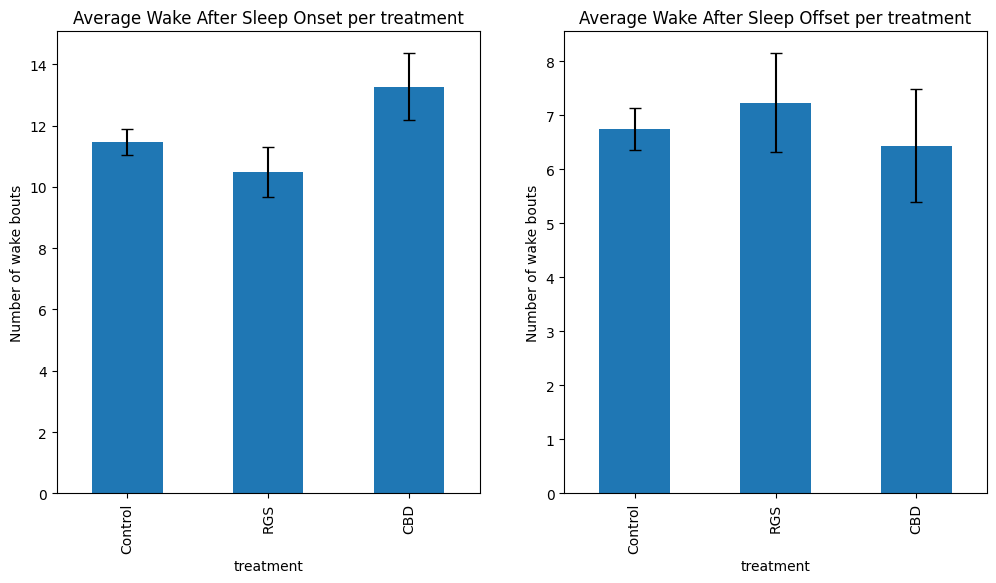

In [15]:
# Perform statistical tests
features = ["WASO", "WASF"]
statistical_tests(features)

# Calculate the mean of the Wake After Sleep Onset (WASO) and the Wake After
# Sleep Offset (WASF) per treatment
WASO_mean = treatments_grouped["WASO"].mean()
WASF_mean = treatments_grouped["WASF"].mean()

# Calculate the standard error of the same columns
WASO_sem = treatments_grouped["WASO"].sem()
WASF_sem = treatments_grouped["WASF"].sem()

# Print results
print("Average amount of wake after sleep onset (first sleep bout): ", "\n" , WASO_mean)
print("\n", "Standard error of the WASO: ", "\n", WASO_sem)
print("\n", "Average amount of wake after sleep offset: ", "\n", WASF_mean)
print("\n", "Standard error of the WASF: ", "\n", WASF_sem, "\n")

# Set subplots in a 1X2 grid
fig, ax = plt.subplots(1,2, figsize=(12,6))

# Plot the WASO
WASO_mean.plot(kind="bar",
               ax=ax[0],
               yerr=WASO_sem,
               capsize=4)
ax[0].set_xlabel("treatment")
ax[0].set_ylabel("Number of wake bouts")
ax[0].set_title("Average Wake After Sleep Onset per treatment")

# Plot the WASF
WASF_mean.plot(kind="bar",
               ax=ax[1],
               yerr=WASF_sem,
               capsize=4)
ax[1].set_xlabel("treatment")
ax[1].set_ylabel("Number of wake bouts")
ax[1].set_title("Average Wake After Sleep Offset per treatment")

#Sleep Cycle Count
Shows the effect of the treatments on the number of sleep cycles in a sleep sequence


Sleep.Cycle.Count: non normally distributed group found. Performing Kruskal-Wallis.

Kruskal-Wallis result for feature: Sleep.Cycle.Count: H = 12.3946, p = 0.0020

Significant difference found in Sleep.Cycle.Count. Running Dunn's post hoc test...

Dunn's post hoc test results for Sleep.Cycle.Count:

          Control       RGS       CBD
Control  1.000000  0.213977  0.002969
RGS      0.213977  1.000000  0.528005
CBD      0.002969  0.528005  1.000000


Statistical test are performed, calculations will be performed next

Average number of sleep cycles:  
 Grouping.Factor
Control    1.751064
RGS        2.035398
CBD        2.112360
Name: Sleep.Cycle.Count, dtype: float64

 Standard error of the sleep cycles mean:  
 Grouping.Factor
Control    0.041622
RGS        0.117206
CBD        0.107718
Name: Sleep.Cycle.Count, dtype: float64


Text(0.5, 1.0, 'Average number of sleep cycles per treatment')

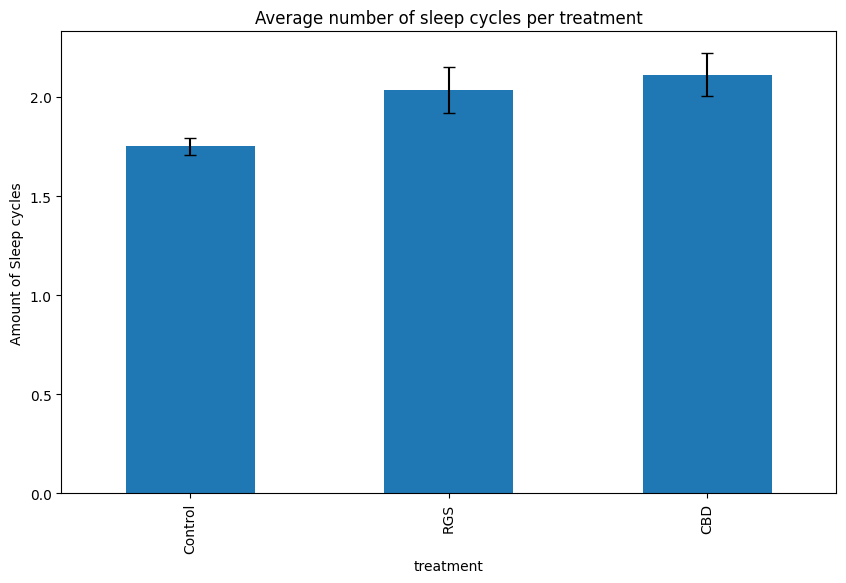

In [16]:
# Perform statistical tests
feature_sleep_cycle = ["Sleep.Cycle.Count"]
statistical_tests(feature_sleep_cycle)

# Calculate the mean of the Sleep Cycle Count per treatment
Sleep_cycle_mean = treatments_grouped["Sleep.Cycle.Count"].mean()

# Calculate the standard error of the same column
Sleep_cycle_sem = treatments_grouped["Sleep.Cycle.Count"].sem()

# Print results
print("Average number of sleep cycles: ", "\n" , Sleep_cycle_mean)
print("\n", "Standard error of the sleep cycles mean: ", "\n", Sleep_cycle_sem)

# Set the plot up
fig, ax = plt.subplots(1,1, figsize=(10,6))

# Plot the average number of sleep cycles
Sleep_cycle_mean.plot(kind="bar",
               ax=ax,
               yerr=Sleep_cycle_sem,
               capsize=4)
ax.set_xlabel("treatment")
ax.set_ylabel("Amount of Sleep cycles")
ax.set_title("Average number of sleep cycles per treatment")